Let's say we have a two wheeled robot, and we want to find the control input which will traj a trajectory with as little error as possible, but also as quickly as possible.

In [41]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import optimize, interpolate
np.set_printoptions(precision=4, suppress=True)

In [42]:
def R(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],
                     [np.sin(theta), np.cos(theta)]])

def fwd_kinematics(x, y, theta, trans_v, angular_v, dt=0.1):    
    pos = np.array([[x], [y]])
    rot = R(theta)
    if abs(angular_v) < 1e-3:
        new_pos = pos + rot * trans_v * dt
    else:
        icc = pos + np.dot(rot, np.array([[0], [trans_v/angular_v]]))
        new_pos = np.dot(R(angular_v*dt), pos - icc) + icc
    new_theta = theta + angular_v * dt;
    return new_pos[0, 0], new_pos[1, 0], new_theta

def plot_traj(x, y, theta, trans_v, angular_v, dt=0.1, N=100):
    xs = np.ndarray(N)
    ys = np.ndarray(N)
    xs[0] = x
    ys[0] = y
    plt.figure(figsize=(6,6))
    plt.scatter(x, y, s=200, marker='o')
    for i in range(1, N):
        x, y, theta = fwd_kinematics(x, y, theta, trans_v, angular_v, dt)
        xs[i] = x
        ys[i] = y
    plt.scatter(xs, ys, marker='*', c='r')
    plt.axis("equal")

In [43]:
# https://stackoverflow.com/questions/849211/shortest-distance-between-a-point-and-a-line-segment
def dist(v, w, p):
    l2 = ((v - w) ** 2).sum()
    if l2 == 0.0:
        return np.linalg.norm(p - v)
    dott = np.dot(p - v, w - v)
    t = max(0, min(1, dott / l2));
    projection = v + t * (w - v);  # Projection falls on the segment
    return np.linalg.norm(p - projection), projection

def angle_diff(a, b):
    diff = a - b
    if diff > np.pi:
        return diff - np.pi * 2
    if diff < -np.pi:
        return diff + np.pi * 2
    return diff

In [44]:
def loss(x, y, theta, path, trans_v, angular_v, dt=0.1, plot=False):
    min_dist_to_path = 1e9
    new_x, new_y, new_theta = fwd_kinematics(x, y, theta, trans_v, angular_v, dt)
    for i in range(len(path)-1):
        p0 = path[i]
        p1 = path[i+1]
        dist_to_path, _ = dist(p0, p1, np.array([new_x, new_y]))
        if dist_to_path < min_dist_to_path:
            min_dist_to_path = dist_to_path
            theta_of_path_segment_with_min_dist = math.atan2(p1[1]-p0[1], p1[0]-p0[0])
    theta_err = abs(angle_diff(theta_of_path_segment_with_min_dist, new_theta))
    
    dist_to_goal = np.hypot(new_x - path[-1, 0], new_y - path[-1, 1])
    
    if plot:
        plt.grid()
        plt.scatter([p[0] for p in path], [p[1] for p in path], s=200)
        arrow_len = max(0.025, abs(trans_v*dt))
        plt.arrow(x, y, np.cos(theta)*arrow_len, np.sin(theta)*arrow_len)
        plt.arrow(new_x, new_y, np.cos(new_theta)*arrow_len, np.sin(new_theta)*arrow_len)
        plt.scatter([x, new_x], [y, new_y])
        plt.axis("equal")
    theta_weight = 0.005
    goal_weight = 0.1
    return theta_weight*theta_err + min_dist_to_path + goal_weight*dist_to_goal, \
           theta_weight*theta_err, \
           min_dist_to_path, \
           goal_weight*dist_to_goal
    
    
def guess_control(x, y, theta, path, v_max=0.15, w_max=1.5, dt=0.1, n_guesses=100):
    def __loss__(params):
        trans_v = params[0]
        angular_v = params[1]
        l, _, _, _ = loss(x, y, theta, path, trans_v, angular_v, dt)
        # print(l)
        return l
    
    us = np.random.uniform(low=[0, -w_max], high=[v_max, w_max], size=[n_guesses, 2])
    min_l = 1e9
    min_u = None
    for u in us:
        l, _, _, _ = loss(x, y, theta, path, u[0], u[1], dt)
        if l < min_l:
            min_l = l
            min_u = u
        
    return min_u[0], min_u[1], min_l
    
    
def optimize_control(x, y, theta, path, v_max=0.15, w_max=1.5, dt=0.1):
    def __loss__(params):
        trans_v = params[0]
        angular_v = params[1]
        l, _, _, _ = loss(x, y, theta, path, trans_v, angular_v, dt)
        # print(l)
        return l
    
    bounds =[(0, v_max), (-w_max, w_max)]
    res = optimize.minimize(fun=__loss__, x0=np.array([v_max*0.9, 0]), bounds=bounds, method='L-BFGS-B')
    
    if res.success:
        return res.x[0], res.x[1], res.fun
    else:
        print(res.x)
        print(res.message)
        return None

(0.0026524966296954055, 0.9995975804187966, 0.028226827140682028)

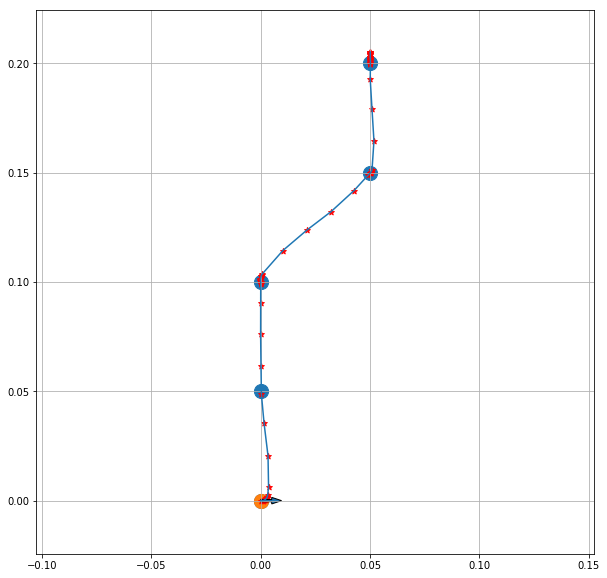

In [45]:
def follow_path(x, y, theta, path, N, dt=0.1):
    xs = np.ndarray(N)
    ys = np.ndarray(N)
    xs[0] = x
    ys[0] = y
    plt.figure(figsize=(10,10))
    plt.grid()
    plt.scatter([p[0] for p in path], [p[1] for p in path], s=200)
    plt.scatter(x, y, s=200, marker='o')
    plt.arrow(x, y, np.cos(theta)*.005, np.sin(theta)*.005)
    for i in range(1, N):
        trans_v, angular_v, l = guess_control(x, y, theta, path, dt=dt)
        new_x, new_y, new_theta = fwd_kinematics(x, y, theta, trans_v, angular_v, dt=dt)
        xs[i] = new_x
        ys[i] = new_y
        arrow_len = max(0.005, abs(trans_v*dt/4))
        x = new_x
        y = new_y
        theta = new_theta
    plt.scatter(xs, ys, marker='*', c='r')
    plt.plot(xs, ys)
    plt.axis("equal")
    
x = 0
y = 0
theta = 0
path = np.array([[0, 0], [0, 1], [0, 2], [1,3], [1,4]]) * 0.05
follow_path(x, y, theta, path, N = 70)